THis NB is used to produce plots for https://github.com/lsst-dm/dmtn-018. Based on LDM-141 spreadsheet. 

In [1]:
%pylab inline
plt.style.use('bmh');

Populating the interactive namespace from numpy and matplotlib


In [2]:
surveyMonths = 120
epochs = 1056                   # Epochs (average visits to any object/area) for the whole survey
surveyFields = 2604             # Survey area in equivalent fields-of-view
visitsPerNight = 1000           # Visits per night (average)
surveyNightsPerYear = 298.35    # Observing nights per year

alertsPerVisit = [
    10000,                      # Average number of alerts per visit due to variables and old transients
    100,                        # Average number of alerts per visit due to new transients
    5050,                       # Average number of alerts per visit due to false positives, 50% of real alerts
]
detectionsPerVisit = sum(alertsPerVisit)      # average number of new DiaSources per visit
forcedDiaSourceMonths = 2.02 # window for forced photometry of transient DiaObjects before and after first DiaSource

last_drp = 11                   # Last DRP number
drps = range(last_drp + 1)      # list of drp numbers, includes 0


In [3]:
# ========== Time is measured in years everywhere below unless specified differently ========

def drp_cutoff_time(n):
    """cutoff time in years for given DRP number (n=1-11), returns 0 for n=0"""
    if n < 2: return n*0.5
    return n-1

def drp_release_time(n):
    """approximate release time in years for given DRP number (n=1-11), returns 0 for n=0"""
    return drp_cutoff_time(n)*1.066666666

last_drp_cutoff = drp_cutoff_time(last_drp)

Number of records
=================

Here is the model for number of records in each of the three tables as a function of time. The model is an over-simplification of actual mess, it simply divides all objects into three classes:
- variable objects - these always stay in the same spot and only change in brightness which is detected on every visit of that area
- transient objects - these are true objects which constantly move and always generate new object (i.e. they are not associated to a known  SSObject)
- false positives (noise) - not actual true objects, but are in practice indistinguishable from transient objects

The number of the respective objects per visit is determined by **alertsPerVisit** array above.

Every visit covering variable object generates one DiaSource, one DiaObject (new version), and one DiaForcedObject (I assume that forced photometry is performed for every new version of DiaObject).

Every visit covering (a new position of) a transient object generates one DiaSource, one *new* DiaObject, and one DiaForcedSource. Later during day processing we add one month of the past forced photometry for this new DiaObject (~10 if we scan whole sky in 3 days) and we continue to do forced photometry in this position for next month (plus ~10 forced sources). And it is assumed that for transient objects we do not observe anything at the same coordinates during next two months.


DiaSource table
---------------

Simply multiply number of visits as a function of time by the average number of detections per visit (which is a sum of all types of objects).




In [4]:
def visits(t):
    """ Total number of visits as function of time """
    return visitsPerNight*surveyNightsPerYear*t

def diaSourceCount(t):
    """Number of DiaSource records as a function of time"""
    t = min(max(t, 0.), last_drp_cutoff)
    return detectionsPerVisit*visits(t)

def diaObjectsVariableCount(t):
    """ number of variable DiaObjects in the whole sky """
    return alertsPerVisit[0]*surveyFields

def diaObjectTransientCount(t):
    """Number of transient DiaObjects as a function of time"""
    t = min(max(t, 0.), last_drp_cutoff)
    return (alertsPerVisit[1]+alertsPerVisit[2])*visits(t)

def diaFSourceCount(t):
    """Number of DiaForcedSource records as a function of time"""
    t = min(max(t, 0.), last_drp_cutoff)
    return diaObjectsVariableCount(t)*epochs/10.*t + \
            diaObjectTransientCount(t)*epochs/surveyMonths*forcedDiaSourceMonths

def diaObjectRecordCount_baseline(t):
    """
    Number of DiaObject records as a function of time for old baseline.
    Reset happens with each new DRP
    """
    release = max(drp for drp in drps if drp_release_time(drp) <= t)
    count = diaObjectsVariableCount(t) + diaObjectTransientCount(t)
    count += diaFSourceCount(t) - diaFSourceCount(drp_cutoff_time(release))
    return count

def diaObjectRecordCount_noreset(t):
    """
    Number of DiaObject records as a function of time for old baseline.
    No resets  with each new DRP
    """
    count = diaObjectsVariableCount(t) + diaObjectTransientCount(t)
    count += diaFSourceCount(t)
    return count


In [5]:
# time range, look one year past last DR cutoff
t = np.arange(0.0, 11.0, 0.1)

# row counts in billions
obj_count = [diaObjectRecordCount_baseline(x)/1e9 for x in t]
obj_count_noreset = [diaObjectRecordCount_noreset(x)/1e9 for x in t]
src_count = [diaSourceCount(x)/1e9 for x in t]
fsrc_count = [diaFSourceCount(x)/1e9 for x in t]

# row sizes from LDM-141
obj_rec_size = 1124    # my estimate = 1536
src_rec_size = 333     # my estimate = 232
fsrc_rec_size = 41     # my estimate = 33

# sizes in TB
obj_size = [s*obj_rec_size/1000 for s in obj_count]
obj_size_noreset = [s*obj_rec_size/1000 for s in obj_count_noreset]
src_size = [s*src_rec_size/1000 for s in src_count]
fsrc_size = [s*fsrc_rec_size/1000 for s in fsrc_count]

In [6]:
def mkplot():
    figure(figsize=(8,5))
def annotate(label):
    xlabel('survey year')
    ylabel(label)
    legend(loc='upper left')

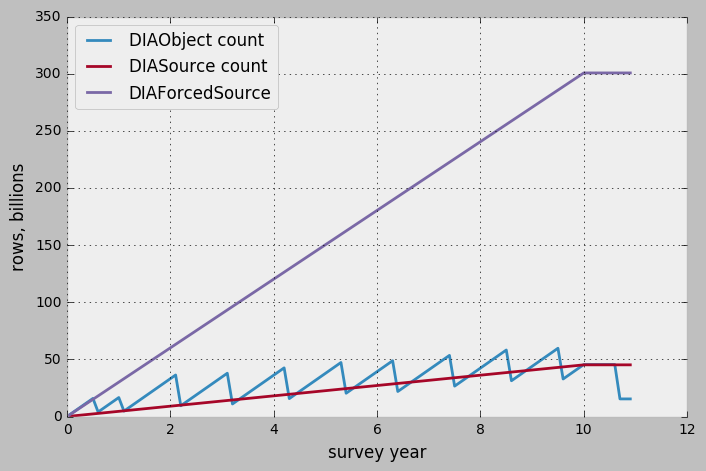

In [7]:
mkplot()
plot(t, obj_count, label='DIAObject count')
plot(t, src_count, label='DIASource count')
plot(t, fsrc_count, label='DIAForcedSource')
annotate('rows, billions');

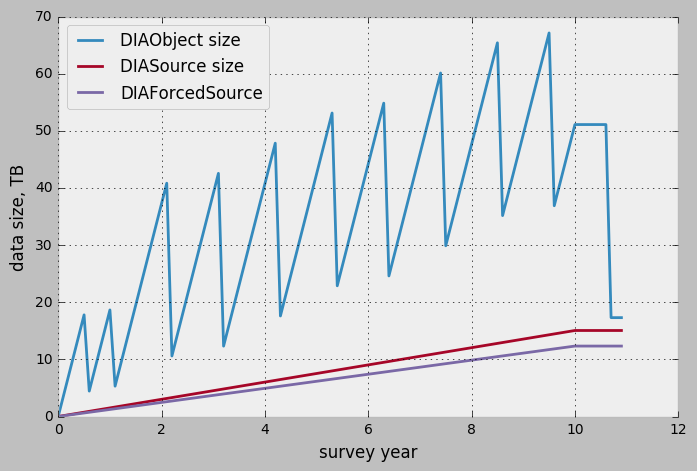

In [8]:
mkplot()
plot(t, obj_size, label='DIAObject size');
plot(t, src_size, label='DIASource size');
plot(t, fsrc_size, label='DIAForcedSource');
annotate('data size, TB');

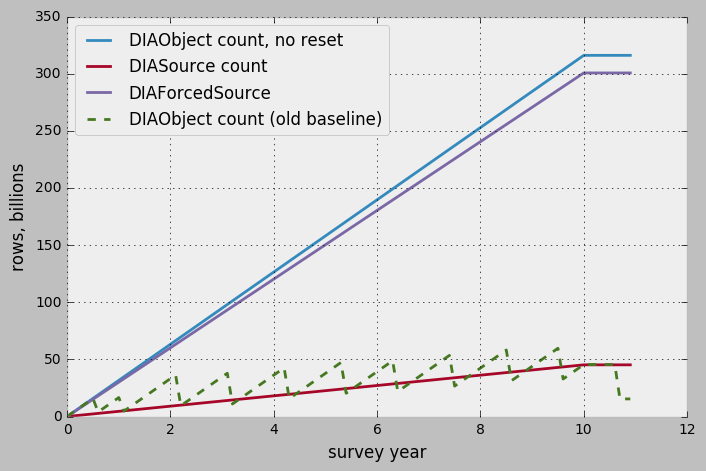

In [9]:
mkplot()
plot(t, obj_count_noreset, label='DIAObject count, no reset')
plot(t, src_count, label='DIASource count')
plot(t, fsrc_count, label='DIAForcedSource')
plot(t, obj_count, '--', label='DIAObject count (old baseline)')
annotate('rows, billions');

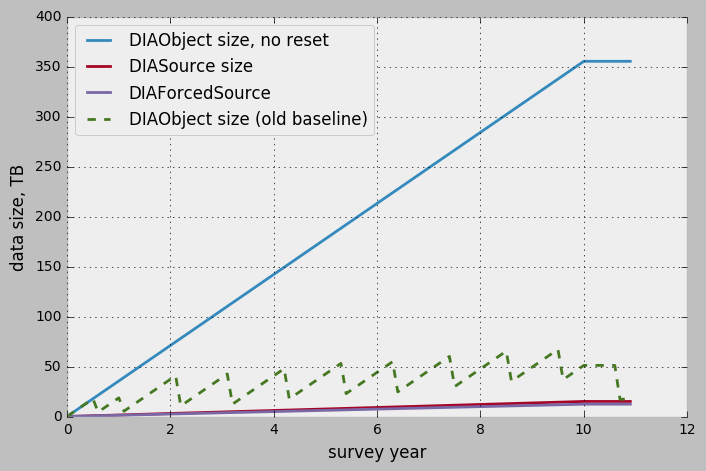

In [10]:
mkplot()
plot(t, obj_size_noreset, label='DIAObject size, no reset');
plot(t, src_size, label='DIASource size');
plot(t, fsrc_size, label='DIAForcedSource');
plot(t, obj_size, '--', label='DIAObject size (old baseline)');
annotate('data size, TB');